In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
import csv
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="h5bench"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 


In [2]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

In [3]:
def detect_h5bench_type(dir: Path):
    if Path(dir / "output-read.csv").exists():
        return "read"
    elif Path(dir / "output-write.csv").exists():
        return "write"
    elif Path(dir / "output-meta.csv").exists():
        return "meta"
    else:
        raise Exception("unknown h5bench benchmark")

def load_rw_output_csv(csv_file: Path):
    def apply_unit_to_value(x):
        if x["unit"] == "KB" or x["unit"] == "KB/s":
            return float(x["value"]) * 2**10
        elif x["unit"] == "MB" or x["unit"] == "MB/s":
            return float(x["value"]) * 2**20
        elif x["unit"] == "GB" or x["unit"] == "GB/s":
            return float(x["value"]) * 2**30
        elif x["unit"] == "TB" or x["unit"] == "TB/s":
            return float(x["value"]) * 2**40
        elif x["unit"] == "seconds":
            return float(x["value"])
        else:
            return x["value"]
    df = pd.read_csv(csv_file).map(lambda x: x.strip()).set_index("metric")
    df.columns = df.columns.str.strip()
    df.index = ["".join(word.capitalize() if i != 0 else word for i,word in enumerate(idx.split(" ")))
                for idx in df.index ]
    # return df
    return pd.DataFrame(df.apply(apply_unit_to_value, axis=1)).transpose().astype({"ranks": int}).loc[0].to_dict()

def load_meta_output_csv(csv_file: Path):
    df = pd.read_csv(csv_file)
    df.columns = ["".join(word.capitalize() if i != 0 else word for i,word in enumerate(col.split("-")))
                for col in df.columns ]

    return df.loc[0].transpose().to_dict()
    

def load_storage(dir_path: Path):
    for run_dir in dir_path.iterdir():
        if not run_dir.is_dir():
            continue
        bench_type = detect_h5bench_type(run_dir)
        if bench_type != "meta":
            yield {
                **load_rw_output_csv(run_dir / f"output-{bench_type}.csv"),
                "benchType": bench_type,
            }
        else:
            yield {
                **load_meta_output_csv(run_dir / "output-meta.csv"),
                "benchType": bench_type,
            }

# detect_h5bench_type(Path("/work/NBB/hiraga/work/mpiio-pmembb/raw/h5bench-pmembb/2024.02.05-17.24.55-default/2024.02.05-17.25.33-169919.nqsv-1/storage/0cef0f0f-0:169919.nqsv"))
# load_rw_output_csv(Path("/work/NBB/hiraga/work/mpiio-pmembb/raw/h5bench-pmembb/2024.02.05-17.24.55-default/2024.02.05-17.25.33-169919.nqsv-1/storage/0cef0f0f-0:169919.nqsv/output-read.csv"))
# load_rw_output_csv(Path("/work/NBB/hiraga/work/mpiio-pmembb/raw/h5bench-pmembb/2024.02.05-17.24.55-default/2024.02.05-18.27.08-169923.nqsv-4/storage/ca9b3427-0:169923.nqsv/output-write.csv"))
# load_meta_output_csv(Path("/work/NBB/hiraga/work/mpiio-pmembb/raw/h5bench-pmembb/2024.02.05-17.24.55-default/2024.02.05-18.27.08-169923.nqsv-4/storage/5e694203-0:169923.nqsv/output-meta.csv"))
# for x in load_storage(Path("/work/NBB/hiraga/work/mpiio-pmembb/raw/h5bench-pmembb/2024.02.05-17.24.55-default/2024.02.05-18.27.08-169923.nqsv-4/storage")):
#     print(x)


In [4]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    # 2024-HPC-193
    # ("h5bench-pmembb/2024.02.05-17.22.58-default", {}),
    # ("h5bench-pmembb/2024.02.05-17.24.08-default", {}),
    # ("h5bench-pmembb/2024.02.05-17.24.55-default", {}),
    ("h5bench-pmembb/2024.02.19-16.50.47-default", {"storageSystem": "PMEMBB",}), 
    ("h5bench-pmembb/2024.02.21-09.38.12-32node",  {"storageSystem": "PMEMBB",}),
    ("h5bench-lustre/2024.02.19-17.34.15-default", {}),
    # ("h5bench-beeond/2024.02.19-16.51.33-default", {}),
    ("h5bench-chfs/2024.02.23-00.34.19-default", {}),
    ("h5bench-chfs/2024.02.23-00.34.01-default", {}),
    ("h5bench-unifyfs/2024.02.25-21.43.58-default", {}),
    ("h5bench-beeond/2024.02.28-07.14.51-setpattern", {}),
    ("h5bench-beeond/2024.02.28-07.16.12-setpattern-64node", {}),
    # ("h5bench-chfs/2024.02.28-09.01.11-local", {"storageSystem": "CHFS-local"}),
    # ("h5bench-chfs/2024.02.28-09.01.36-local", {"storageSystem": "CHFS-local"}),
    # ("h5bench-chfs/2024.02.29-03.58.29-default", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src_rw = []
src_meta = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        try:
            storage_dir = job_dir / "storage"
            for output_dict in load_storage(storage_dir):
                if output_dict["benchType"] == "write":
                    runid = 0
                elif output_dict["benchType"] == "read":
                    runid = 1
                elif output_dict["benchType"] == "meta":
                    runid = 2
                else:
                    raise Exception("unknown benchType")
                job_params = json.loads(Path(job_dir / f"job_params_{runid}.json").read_text())
                if runid < 2:
                    src_rw.append({
                        **default_metadata,
                        **job_start,
                        **job_nodelist,
                        **job_params,
                        **output_dict,
                        "runid": runid,
                        **metadata,
                    })
                else:
                    src_meta.append({
                        **default_metadata,
                        **job_start,
                        **job_nodelist,
                        **job_params,
                        **output_dict,
                        "runid": runid,
                        **metadata,
                    })
        except FileNotFoundError as e:
            print(e)
        except Exception as e:
            print(f'{job_dir}, {e}')

df_src_rw = (
    pd.DataFrame(src_rw)
    .assign(bwGB=lambda x: x['observedRate'] / 1000**3)
    # .drop(columns=[
    #     'phaseDurationsSec',
    # ])
)
# df_src_meta = (
#     pd.DataFrame(src_meta)
#     .assign(readMB=lambda x: x["readRateMin [mib/s]"] * 2**20 / 1000**2)
#     .assign(writeMB=lambda x: x["writeRateMin [mib/s]"] * 2**20 / 1000**2)
#     # .drop(columns=[
#     #     'phaseDurationsSec',
#     # ])
#     # .assign(bwGB=lambda x: x['writeBandwidthByte'] / 1000**3)
# )

df_src_rw.head()
# df_src_meta.head()


,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,lustre_version,...,UNIFYFS_MARGO_SERVER_POOL_SIZE,UNIFYFS_MARGO_CLIENT_POOL_SIZE,UNIFYFS_RUNSTATE_DIR,UNIFYFS_SERVER_MAX_APP_CLIENTS,UNIFYFS_SERVER_INIT_TIMEOUT,UNIFYFS_SERVER_LOCAL_EXTENTS,UNIFYFS_CLIENT_LOCAL_EXTENTS,UNIFYFS_CLIENT_NODE_LOCAL_EXTENTS,beeond_chunksize,bwGB
0,2024.02.19-16.50.47,"[bnode104, bnode105, bnode106, bnode107, bnode...",8,32,256,174253.nqsv,0,/dev/dax0.0,0.0,2.12.9_ddn38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.355583
1,2024.02.19-16.50.47,"[bnode104, bnode105, bnode106, bnode107, bnode...",8,32,256,174253.nqsv,1,/dev/dax0.0,0.0,2.12.9_ddn38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,471.037653
2,2024.02.19-16.50.47,"[bnode018, bnode019, bnode020, bnode029, bnode...",16,32,512,174256.nqsv,0,/dev/dax0.0,0.0,2.12.9_ddn38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.755016
3,2024.02.19-16.50.47,"[bnode018, bnode019, bnode020, bnode029, bnode...",16,32,512,174256.nqsv,1,/dev/dax0.0,0.0,2.12.9_ddn38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,938.771403
4,2024.02.19-16.50.47,"[bnode015, bnode018, bnode019, bnode020, bnode...",32,32,1024,174258.nqsv,1,/dev/dax0.0,0.0,2.12.9_ddn38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1876.866349


In [5]:
df_src_rw.columns

Index(['job_start', 'nodelist', 'nnodes', 'ppn', 'np', 'jobid', 'runid',
       'pmem_path', 'pmem_size', 'lustre_version', 'lustre_stripe_size',
       'lustre_stripe_count', 'spack_env_name', 'operation', 'ranks',
       'collectiveData', 'collectiveMeta', 'subfiling', 'totalComputeTime',
       'totalSize', 'rawTime', 'rawRate', 'metadataTime', 'observedRate',
       'observedTime', 'benchType', 'storageSystem', 'chfs_chunk_size',
       'chfs_log_priority', 'chfs_nthreads', 'chfs_niothreads',
       'chfs_rdma_thresh', 'chfs_async_access', 'chfs_lookup_local',
       'chfs_version', 'fi_universe_size', 'UNIFYFS_LOG_VERBOSITY',
       'UNIFYFS_LOGIO_SPILL_DIR', 'UNIFYFS_LOGIO_SPILL_SIZE',
       'UNIFYFS_LOGIO_SHMEM_SIZE', 'UNIFYFS_LOGIO_CHUNK_SIZE',
       'UNIFYFS_MARGO_TCP', 'UNIFYFS_MARGO_CLIENT_TIMEOUT',
       'UNIFYFS_MARGO_SERVER_TIMEOUT', 'UNIFYFS_MARGO_SERVER_POOL_SIZE',
       'UNIFYFS_MARGO_CLIENT_POOL_SIZE', 'UNIFYFS_RUNSTATE_DIR',
       'UNIFYFS_SERVER_MAX_APP_CLIENTS

In [6]:
df = df_src_rw

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "storageSystem",
        "spack_env_name",
        "nnodes",
        "benchType",
        "rawTime",
        "metadataTime",
        "observedTime",
        "rawRate",
        "observedRate",
        "bwGB",
        # "segmentCount",
        # "blockSize",
        # "bwGB",
    ]]
    .sort_values(["benchType", "nnodes"])
    # .head()
)


,storageSystem,spack_env_name,nnodes,benchType,rawTime,metadataTime,observedTime,rawRate,observedRate,bwGB
16,PMEMBB,mpiio-pmembb-deferred-open,1,read,1.372,0.003,1.442,6.261203e+10,5.956046e+10,59.560459
23,PMEMBB,mpiio-pmembb,1,read,1.358,0.003,1.431,6.325306e+10,6.002217e+10,60.022168
33,Lustre,mpiio-pmembb,1,read,14.442,0.084,15.241,5.947456e+09,5.636071e+09,5.636071
56,CHFS,chfs,1,read,2.954,0.010,3.307,2.907800e+10,2.597489e+10,25.974888
60,CHFS,chfs,1,read,3.637,0.008,3.716,2.361588e+10,2.311766e+10,23.117661
64,CHFS,chfs,1,read,3.148,0.011,3.411,2.728700e+10,2.518032e+10,25.180320
89,UnifyFS,unifyfs,1,read,42.450,9.273,51.967,2.022930e+09,1.652489e+09,1.652489
103,BeeOND,mpiio-pmembb,1,read,9.772,0.029,9.902,8.789651e+09,8.673686e+09,8.673686
8,PMEMBB,mpiio-pmembb,2,read,1.364,0.010,1.444,1.259564e+11,1.189813e+11,118.981332
21,PMEMBB,mpiio-pmembb-deferred-open,2,read,1.382,0.009,1.457,1.243221e+11,1.179377e+11,117.937654


<Axes: xlabel='storageSystem,spack_env_name,nnodes,benchType'>

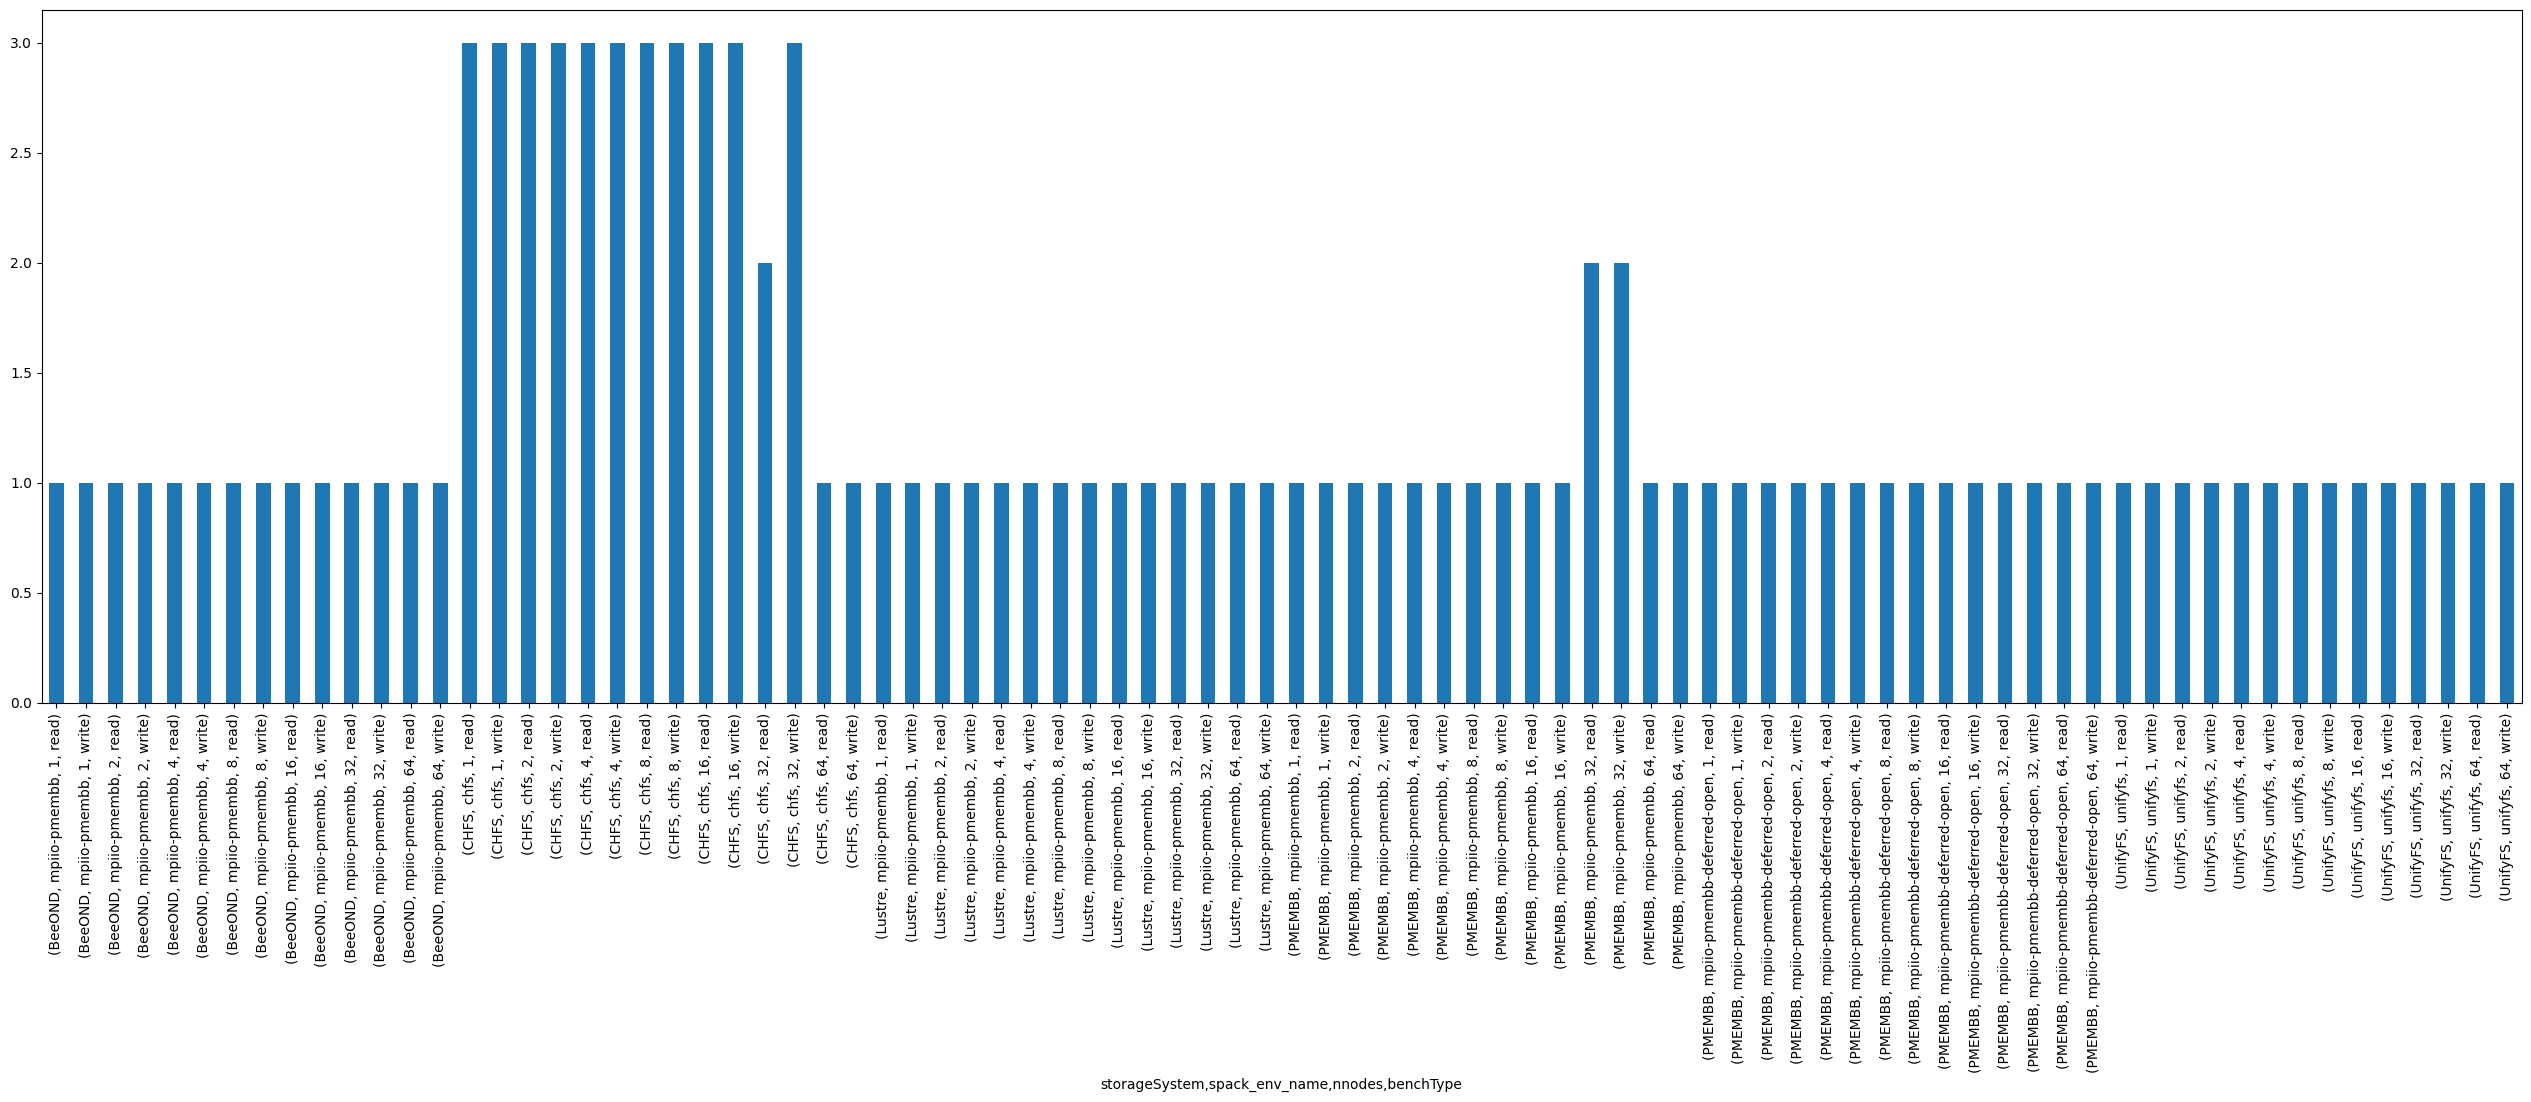

In [7]:
df = df_src_rw
same_setting_columns = [
    "storageSystem", "spack_env_name", "nnodes", "benchType"]
same_setting_grouper = df.groupby(same_setting_columns)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# display(same_setting_grouper.size())
(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


read


storageSystem,Lustre,BeeOND,CHFS,UnifyFS,PMEMBB
nnodes,,,,,
1,5.636071,8.673686,25.974888,1.652489,60.022168
2,5.820754,28.690382,49.258980,3.311420,118.981332
4,10.946798,65.990025,80.670223,6.647536,235.349175
8,15.868830,129.541582,156.943474,13.114683,471.037653
16,22.932978,60.740501,287.466456,26.725434,938.243122
32,28.908351,69.068443,538.068134,51.482699,1873.567814
64,30.013231,91.386167,987.315271,103.770705,3720.747348


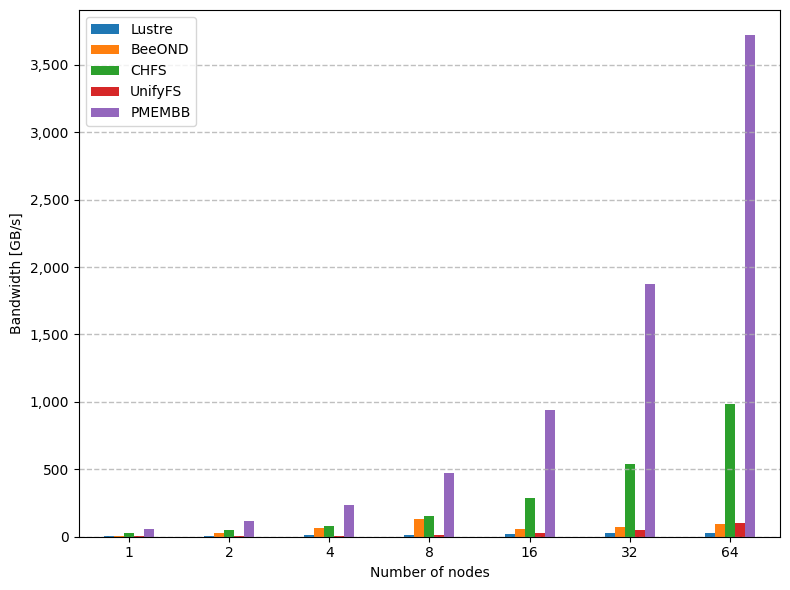

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


write


storageSystem,Lustre,BeeOND,CHFS,UnifyFS,PMEMBB
nnodes,,,,,
1,2.342905,2.859374,9.037685,10.781442,22.921167
2,3.888019,5.970005,18.187039,20.956219,45.348412
4,5.834713,14.157286,35.953171,38.491497,89.029303
8,9.920301,33.547990,65.405909,74.619688,170.355583
16,12.698071,34.745212,115.057879,150.258357,292.092136
32,12.847321,71.591736,192.748469,291.130063,574.786883
64,13.858786,136.473660,145.267605,559.037238,1145.691116


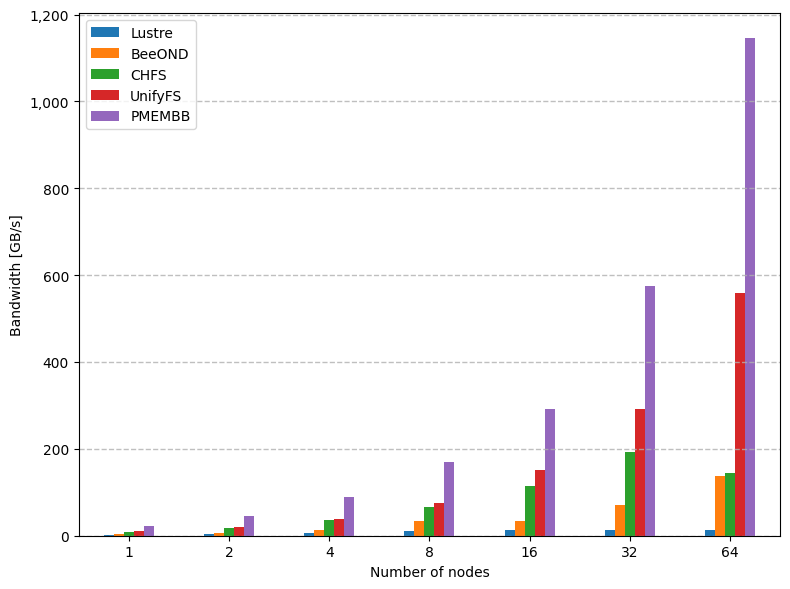

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    .query("spack_env_name != 'mpiio-pmembb-deferred-open'")
)

for (benchType,), df_sub in df.groupby(["benchType"]):
    print(benchType)
    df_plot = df_sub.pivot(index="nnodes", columns=["storageSystem"], values=["bwGB"])
    df_plot.columns = df_plot.columns.get_level_values(1)
    df_plot = df_plot.loc[:, [
        "Lustre",
        "BeeOND",
        "CHFS",
        # "CHFS-local",
        "UnifyFS",
        "PMEMBB"]]#.rename({"BeeOND": "BeeOND on PMEM"}, axis=1)
    display(df_plot)

    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        ax=fig.add_subplot(),
        kind="bar",
        # kind="line",
        # xlabel="Transfer size [B]",
        xlabel="Number of nodes",
        ylabel="Bandwidth [GB/s]",
        # style=".-",
        legend=True,
        rot=0,
    )

    # ax.set_title(f"h5bench {benchType.capitalize()}")
    # ax.set_xscale("log", base=2)
    # ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
    # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
    # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
    ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

    # legend_title = ax.get_legend().get_title().get_text()
    # ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.legend(title="")
    plt.tight_layout()

    fig.show()
    plt.show()
    save(fig, F"h5bench_{benchType}")
